In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.30.0


In [2]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config('config.json')
print(ws.name, ws.location, ws.resource_group, sep='\t')

mlops-workshop	westeurope	mlops-workshop


In [3]:
from azureml.core import Dataset

tveer_components = os.path.join(os.getcwd(), 'data/tveer/components')
os.makedirs(tveer_components, exist_ok=True)


In [8]:
dataset_tveer = Dataset.get_by_name(ws, name='components')

In [9]:
# mount dataset onto the mounted_path of a Linux-based compute
mnt_ctx_tveer = dataset_tveer.mount(tveer_components)

mnt_ctx_tveer.start()

In [10]:
component_names = os.listdir("data/tveer/components")

In [11]:
component_names

['Object 1', 'Object 11', 'Object 6', 'Object 8', 'Object 9']

In [12]:
import math
def print_multiple_images(*images, **kwargs):
    amount_of_images = len(images)
    rows = math.ceil(len(images) / 5)
    cols = 5 if len(images) > 5 else len(images)
    fig, axes = plt.subplots(rows, cols, figsize=(24, 3 * rows))
    axes_1d = axes.ravel() if amount_of_images > 1 else [axes]
    for i in range(len(axes_1d)):
        try:
            axes_1d[i].imshow(images[i], **kwargs)
            axes_1d[i].axis('off')    
            axes_1d[i].set_title(images[i].shape, fontdict={'fontsize': 20})
        except IndexError:
            axes_1d[i].axis('off')
    plt.show()

In [13]:
from glob import glob
all_components = glob('data/tveer/components/')

In [14]:
import json

In [15]:
all_components = []
all_labels = []
all_sizes = []
for comp in os.listdir('data/tveer/components'):
    for img_uri in glob(os.path.join('data/tveer/components', comp) + "/*.png"):
        try:
            size = img_uri.split(".png")[-2]
            with open(size + '--size.json', "r") as f:
                all_sizes.append(json.load(f))
                img = plt.imread(img_uri)[:,:,:3]
                all_components.append(img)
                all_labels.append(comp)
        except FileNotFoundError:
            pass

In [16]:
all_labels_np = np.array(all_labels)
all_components_np = np.array(all_components)
all_sizes_np = np.array(all_sizes)

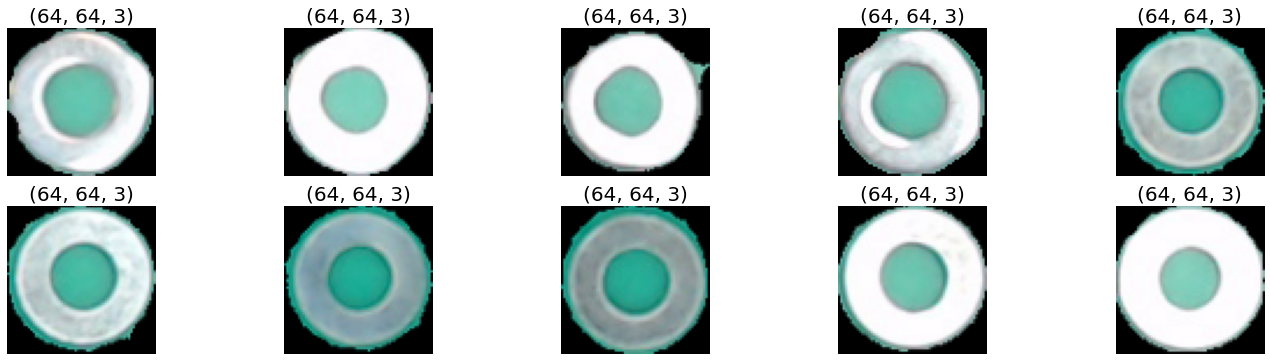

['Object 1' 'Object 1' 'Object 1' 'Object 1' 'Object 1' 'Object 1'
 'Object 1' 'Object 1' 'Object 1' 'Object 1']
[ 92.63368718  93.33809512  94.79451461  89.80534505 100.40916293
  98.2903861   99.70456359  96.87620967  95.46203434  96.87620967]


In [17]:
print_multiple_images(*all_components_np[:10])
print(all_labels_np[:10])
print(all_sizes_np[:10])

## Train and test splitted data

In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [19]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(sorted(all_labels_np))

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

import math

training_indices = []
test_indices = []
for obj in range(0, onehot_encoded.shape[1]):
    obj_indices = np.where(onehot_encoded[:,obj] == 1)[0]
    np.random.shuffle(obj_indices)
    training_samples = math.floor(0.7 * len(obj_indices))
    training_indices.extend(obj_indices[:training_samples])
    test_indices.extend(obj_indices[training_samples:])

print(f"{len(training_indices)} training indices")
print(f"{len(test_indices)} test indices")

192 training indices
84 test indices


In [20]:
X_train_conv = all_components_np[training_indices]
X_train_values = all_sizes_np[training_indices]
X_test_conv = all_components_np[test_indices]
X_test_values = all_sizes_np[test_indices]

y_train = onehot_encoded[training_indices]
y_test = onehot_encoded[test_indices]


In [21]:
train_test_data = os.path.join(os.getcwd(), 'data/tveer/train_test_data')
os.makedirs(train_test_data, exist_ok=True)

In [22]:
np.save(f"{train_test_data}/X_train_conv.npy", X_train_conv)
np.save(f"{train_test_data}/X_train_values.npy", X_train_values)
np.save(f"{train_test_data}/X_test_conv.npy", X_test_conv)
np.save(f"{train_test_data}/X_test_values.npy", X_test_values)
np.save(f"{train_test_data}/y_train.npy", y_train)
np.save(f"{train_test_data}/y_test.npy", y_test)

In [15]:
from azureml.core import Datastore

In [16]:
datastore = Datastore(ws)

## Generate an Augmented dataset

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
train_generator = ImageDataGenerator(rotation_range=360)


In [27]:
time_to_repeat_generator = 5
image_generator = train_generator.flow([np.repeat(X_train_conv, time_to_repeat_generator, 0), np.repeat(X_train_values, time_to_repeat_generator, 0)], np.repeat(y_train, time_to_repeat_generator, 0), batch_size = 32)

Because we want to keep hold of the data that we trained with, we are going to save a few of this data to a new datastore.

In [7]:
tveer_generator_path = os.path.join(os.getcwd(), 'data/tveer/generator')
os.makedirs(tveer_generator_path, exist_ok=True)

In [31]:
from typing import Generator
for i in range(20):
    generated_data, generated_labels = image_generator.next()
    for j in range(generated_data[1].shape[0]):
        plt.imsave(f"{tveer_generator_path}/{component_names[np.argmax(generated_labels[j])]}-{i}-{j}.png", generated_data[0][j])
        with open(f"{tveer_generator_path}/{component_names[np.argmax(generated_labels[j])]}-{i}-{j}--size.json", "w") as f:
            json.dump(generated_data[1][j], f)

In [32]:
datastore.upload(src_dir='data/tveer/generator', target_path='generated')

Uploading an estimated of 1280 files
Uploading data/tveer/generator/Object 1-0-0--size.json
Uploaded data/tveer/generator/Object 1-0-0--size.json, 1 files out of an estimated total of 1280
Uploading data/tveer/generator/Object 1-0-0.png
Uploaded data/tveer/generator/Object 1-0-0.png, 2 files out of an estimated total of 1280
Uploading data/tveer/generator/Object 1-0-12--size.json
Uploaded data/tveer/generator/Object 1-0-12--size.json, 3 files out of an estimated total of 1280
Uploading data/tveer/generator/Object 1-0-12.png
Uploaded data/tveer/generator/Object 1-0-12.png, 4 files out of an estimated total of 1280
Uploading data/tveer/generator/Object 1-0-26--size.json
Uploaded data/tveer/generator/Object 1-0-26--size.json, 5 files out of an estimated total of 1280
Uploading data/tveer/generator/Object 1-0-26.png
Uploaded data/tveer/generator/Object 1-0-26.png, 6 files out of an estimated total of 1280
Uploading data/tveer/generator/Object 1-0-29--size.json
Uploaded data/tveer/generator

$AZUREML_DATAREFERENCE_407886ebb85e4ef6ab60c45b54562516

In [37]:
generator_data = Dataset.File.from_files(
    [
        (datastore, 'generated')
    ],
    validate=False)

KeyboardInterrupt: 

In [34]:
generator_dataset = generator_data.register(
    workspace=ws,
    name="generator_data",
    description="Components of the 't Veer dataset which have been generated and slightly augmented with rotations.",
    create_new_version=True)

NameError: name 'generator_data' is not defined

In [5]:
from glob import glob
import json

In [8]:
all_generated_images = []
all_generated_sizes = []
all_generated_labels = []
for img in sorted(glob(f"{tveer_generator_path}/*.png")):
    size_name = img.replace('.png', '--size.json')
    all_generated_images.append(plt.imread(img)[:,:,:3] / 255)
    all_generated_labels.append(img.split('-')[-3].split('/')[-1]) # Get the Object name (data/tveer/generator/Object 1-0-1.png --> Object 1)
    with open(size_name, 'r') as f:
        all_generated_sizes.append(json.load(f))

In [9]:
all_generated_images_np = np.asarray(all_generated_images)
all_generated_sizes_np = np.asarray(all_generated_sizes)
all_generated_labels = np.asarray(all_generated_labels)

In [12]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(all_generated_labels)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [13]:
np.save(f"data/tveer/train_test_data/X_train_conv_generated.npy", all_generated_images_np)
np.save(f"data/tveer/train_test_data/X_train_values_generated.npy", all_generated_sizes_np)
np.save(f"data/tveer/train_test_data/y_train_generated.npy", onehot_encoded)

In [17]:
datastore.upload(src_dir='data/tveer/train_test_data', target_path='train_test_data')

Uploading an estimated of 9 files
Uploading data/tveer/train_test_data/X_test_values.npy
Uploaded data/tveer/train_test_data/X_test_values.npy, 1 files out of an estimated total of 9
Uploading data/tveer/train_test_data/X_train_values.npy
Uploaded data/tveer/train_test_data/X_train_values.npy, 2 files out of an estimated total of 9
Uploading data/tveer/train_test_data/X_train_values_generated.npy
Uploaded data/tveer/train_test_data/X_train_values_generated.npy, 3 files out of an estimated total of 9
Uploading data/tveer/train_test_data/y_test.npy
Uploaded data/tveer/train_test_data/y_test.npy, 4 files out of an estimated total of 9
Uploading data/tveer/train_test_data/y_train.npy
Uploaded data/tveer/train_test_data/y_train.npy, 5 files out of an estimated total of 9
Uploading data/tveer/train_test_data/y_train_generated.npy
Uploaded data/tveer/train_test_data/y_train_generated.npy, 6 files out of an estimated total of 9
Uploading data/tveer/train_test_data/X_test_conv.npy
Uploaded data

$AZUREML_DATAREFERENCE_9384a1d43d6248c28b5842d7b8720e1b

In [18]:
train_test_data = Dataset.File.from_files(
    [
        (datastore, 'train_test_data')
    ],
    validate=False)

In [19]:
train_test_dataset = train_test_data.register(
    workspace=ws,
    name="train_test_dataset",
    description="A part of the components that have been processed and split in training and testing sets for an AI model.",
    create_new_version=True)